In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import pandas as pd
import numpy as np
from bsmcalls import readVCF
from bsmcalls import preprocessing
import subprocess
import os
import io
import bsmutils
from matplotlib import pyplot as plt
import attila_utils
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
annotlist = readVCF.read_annotlist(withFORMAT=False)
formatstr = readVCF.make_formatstr(annotlist)
formatstr

'%CHROM\t%POS\t%REF\t%ALT\t%QUAL\t%FILTER/PASS\t%FILTER/HC\t%FILTER/EXT\t%INFO/AC\t%INFO/AF\t%INFO/AN\t%INFO/BaseQRankSum\t%INFO/DP\t%INFO/DS\t%INFO/END\t%INFO/ExcessHet\t%INFO/FS\t%INFO/InbreedingCoeff\t%INFO/MLEAC\t%INFO/MLEAF\t%INFO/MQ\t%INFO/MQRankSum\t%INFO/NEGATIVE_TRAIN_SITE\t%INFO/POSITIVE_TRAIN_SITE\t%INFO/QD\t%INFO/RAW_MQandDP\t%INFO/ReadPosRankSum\t%INFO/SOR\t%INFO/VQSLOD\t%INFO/culprit\t%INFO/ChromatinState_DLPFC\t%INFO/szdbCNVcount\t%INFO/GWASpval\n'

In [3]:
cmc_clinical_path = bsmutils.get_bsmdir() + '/resources/CMC_Human_clinical_metadata.csv'
sel_clin_cols = ['Reported Gender', 'Sex', 'Ethnicity', 'ageOfDeath', 'Dx']
def read_clinical(fpath=cmc_clinical_path, sel_cols=sel_clin_cols):
    # CMC_Human_clinical_metadata.csv
    clinical = pd.read_csv(fpath, index_col='Individual ID')[sel_cols]
    return(clinical)

clin = read_clinical()
clin.head()

,Reported Gender,Sex,Ethnicity,ageOfDeath,Dx
Individual ID,,,,,
CMC_MSSM_001,Female,XX,Caucasian,70.0,BP
CMC_MSSM_002,Male,XY,Caucasian,42.0,BP
CMC_MSSM_003,Male,XY,Caucasian,58.0,BP
CMC_MSSM_004,Female,XX,Caucasian,28.0,AFF
CMC_MSSM_005,Female,XX,Caucasian,36.0,AFF


In [4]:
def readVCFnew(vcfpath='/home/attila/projects/bsm/results/calls/annotated/PITT_010_brain.ploidy_50.filtered.vcf'):
    formatstr = '%CHROM\t%POS\t%REF\t%ALT\t%QUAL\t%INFO/AC\t%INFO/AF\t%INFO/AN\t%INFO/DP\t%INFO/MQ\t[%AD]\n'
    colnames = ['CHROM', 'POS', 'REF', 'ALT', 'QUAL', 'AC', 'AF', 'AN', 'DP', 'MQ', 'AD']
    cmd = ['bcftools', 'query', '-f', formatstr, vcfpath]
    p =  subprocess.run(cmd, capture_output=True)
    calls = pd.read_csv(io.BytesIO(p.stdout), sep='\t', names=colnames, na_values='.', dtype={'CHROM': 'object'})
    sample = readVCF.sample_fromVCF(vcfpath)
    indiv_id, tissue = readVCF.convert_sample(sample)
    calls['Individual ID'] = indiv_id
    calls['Tissue'] = tissue
    calls['Mutation'] = [str(a) + '/' + str(b) for a, b in zip(calls['REF'], calls['ALT'])]
    calls = calls.set_index(['Individual ID', 'Tissue', 'CHROM', 'POS', 'Mutation'], drop=True)
    return(calls)

In [5]:
def processAD(calls):
    s = calls.AD.str.split(',')
    l = [s.apply(lambda x: np.int64(x[i])).to_frame(name) for name, i in zip(['AD_REF', 'AD_ALT'], [0, 1])]
    AD = pd.concat(l, axis=1)
    calls = pd.concat([calls.drop('AD', axis=1), AD], axis=1)
    calls['AD_frac'] = calls.AD_ALT / (calls.AD_ALT + calls.AD_REF)
    return(calls)

In [6]:
def readVCFs(vcflistpath=bsmutils.get_bsmdir() + '/results/calls/filtered-vcfs.tsv',
        vcfdir=bsmutils.get_bsmdir() + '/results/calls/'):
    vcflist = pd.read_csv(vcflistpath, sep='\t', names=['sample', 'file'], index_col='sample')
    vcflist['filepath'] = [vcfdir + os.sep + 'annotated' + os.sep + f for f in vcflist['file']]
    l = [readVCFnew(y) for y in vcflist['filepath']]
    calls = pd.concat(l, axis=0)
    calls = calls.dropna(axis=1)
    calls = processAD(calls)
    return(calls)

calls = readVCFs()
calls['AD_frac - AF'] = calls.AD_frac - calls.AF

In [7]:
def get_data(categorize=True):
    '''
    Get all data for BSM project: calls and clinical data

    Arguments
    merge: wether to merge calls and clinical data
    cols2drop: list of columns to drop in clinical data

    Value: calls and clinical data frame separately (in a tuple) or merged
    into a single data frame
    '''
    clin = read_clinical()
    calls = readVCFs()
    if categorize:
        calls = preprocessing.convert2categorical(calls)
        clin = preprocessing.convert2categorical(clin)
    clin = preprocessing.drop_unused_categories(clin)
    calls = preprocessing.drop_unused_categories(calls)
    data = (calls, clin)
    calls, clin = calls.align(clin, level='Individual ID', axis=0)
    data = pd.concat([calls, clin], axis=1)
    return(data)

data = get_data()
data

REF ALT    QUAL  AC    AF  AN  \
Individual ID Tissue  CHROM POS       Mutation                                 
CMC_MSSM_027  NeuN_pl 1     11973569  C/T        C   T   83.07   1  0.02  50   
                            67324428  A/T        A   T  203.16   3  0.06  50   
                            182008461 C/T        C   T  164.46   3  0.06  50   
                            207598957 C/T        C   T  168.14   3  0.06  50   
                            219342012 C/T        C   T   78.80   1  0.02  50   
...                                             ..  ..     ...  ..   ...  ..   
CMC_MSSM_331  muscle  3     69166433  T/G        T   G   53.75   3  0.06  50   
                      6     36807240  C/T        C   T  147.44   5  0.10  50   
                      12    86938406  T/G        T   G  194.65   8  0.16  50   
                      16    48114834  C/T        C   T  162.11   6  0.12  50   
                      17    29109599  T/G        T   G  202.97   8  0.16  50   

                                                 DP    MQ  AD_REF  AD_ALT  \
Individual ID Tissue  CHROM POS       Mutation                              
CMC_MSSM_027  NeuN_pl 1     11973569  C/T       199  60.0     192       6   
                            67324428  A/T       196  60.0     184      10   
                            182008461 C/T       167  60.0     154      10   
                            207598957 C/T       195  60.0     183      10   
                            219342012 C/T       216  60.0     208       5   
...                                             ...   ...     ...     ...   
CMC_MSSM_331  muscle  3     69166433  T/G        60  60.0      56       4   
                      6     36807240  C/T        57  60.0      49       6   
                      12    86938406  T/G        50  60.0      41       9   
                      16    48114834  C/T        52  60.0      45       7   
                      17    29109599  T/G        62  60.0      50      12   

                                                 AD_frac Reported Gender Sex  \
Individual ID Tissue  CHROM POS       Mutation                                 
CMC_MSSM_027  NeuN_pl 1     11973569  C/T       0.030303            Male  XY   
                            67324428  A/T       0.051546            Male  XY   
                            182008461 C/T       0.060976            Male  XY   
                            207598957 C/T       0.051813            Male  XY   
                            219342012 C/T       0.023474            Male  XY   
...                                                  ...             ...  ..   
CMC_MSSM_331  muscle  3     69166433  T/G       0.066667          Female  XX   
                      6     36807240  C/T       0.109091          Female  XX   
                      12    86938406  T/G       0.180000          Female  XX   
                      16    48114834  C/T       0.134615          Female  XX   
                      17    29109599  T/G       0.193548          Female  XX   

                                                Ethnicity  ageOfDeath   Dx  
Individual ID Tissue  CHROM POS       Mutation                              
CMC_MSSM_027  NeuN_pl 1     11973569  C/T       Caucasian        66.0  SCZ  
                            67324428  A/T       Caucasian        66.0  SCZ  
                            182008461 C/T       Caucasian        66.0  SCZ  
                            207598957 C/T       Caucasian        66.0  SCZ  
                            219342012 C/T       Caucasian        66.0  SCZ  
...                                                   ...         ...  ...  
CMC_MSSM_331  muscle  3     69166433  T/G       Caucasian        67.0  SCZ  
                      6     36807240  C/T       Caucasian        67.0  SCZ  
                      12    86938406  T/G       Caucasian        67.0  SCZ  
                      16    48114834  C/T       Caucasian        67.0  SCZ  
                      17    29109599  T

In [8]:
data.to_csv('../../results/2022-01-20-fraction-of-alt-reads/data.csv')

['named-figure/AD_frac-AF.png', 'named-figure/AD_frac-AF.pdf']

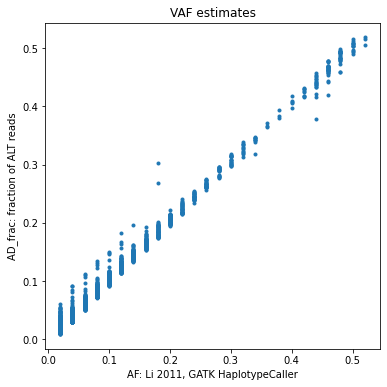

In [9]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(x='AF', y='AD_frac', data=data, marker='.')
ax.set_xlabel('AF: Li 2011, GATK HaplotypeCaller')
ax.set_ylabel('AD_frac: fraction of ALT reads')
ax.set_title('VAF estimates')
attila_utils.savefig(fig, 'AD_frac-AF')

['named-figure/DeltaVAF-DP-MQ.png', 'named-figure/DeltaVAF-DP-MQ.pdf']

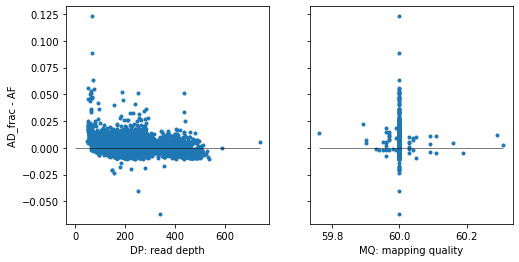

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4), sharey=True)
ax[0].scatter(y='AD_frac - AF', x='DP', data=calls, marker='.')
ax[1].scatter(y='AD_frac - AF', x='MQ', data=calls, marker='.')
ax[0].set_ylabel('AD_frac - AF')
ax[0].set_xlabel('DP: read depth')
ax[1].set_xlabel('MQ: mapping quality')
ax[0].hlines(0, 0, calls.DP.max(), color='black', linewidth=0.5, linestyle='solid')
ax[1].hlines(0, calls.MQ.min(), calls.MQ.max(), color='black', linewidth=0.5, linestyle='solid')
attila_utils.savefig(fig, 'DeltaVAF-DP-MQ')

In [11]:
%connect_info

{
  "shell_port": 56449,
  "iopub_port": 38217,
  "stdin_port": 58841,
  "control_port": 58575,
  "hb_port": 58483,
  "ip": "127.0.0.1",
  "key": "4b77b2ae-3cb605f01c07d5e5b41be2bd",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-6eb3e1bc-cdb9-44f5-975e-84a0b79f9ba5.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
